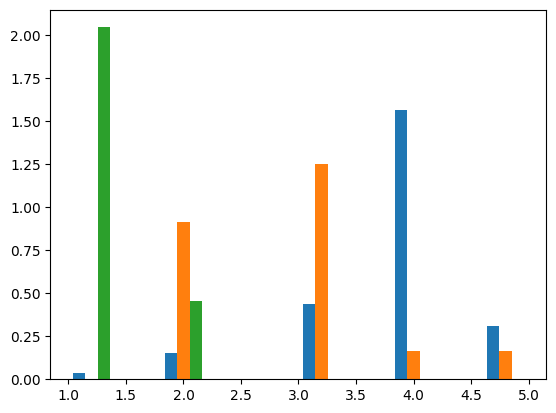

In [12]:
import json
import matplotlib.pyplot as plt

with open('../final_data/rag_doc_naturalness.json', 'r') as f:
    data = json.load(f)
    scores = [p[1] for p in data]
    adv_scores = [2, 2, 3, 3, 3, 3, 3, 3, 4, 5, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 5, 3, 4, 3, 2]
    beast_scores = [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1]
    plt.hist([scores, adv_scores, beast_scores], density=True)

3

In [7]:
import numpy as np

adv readability avg 2.85
beast readability avg 1.7


(array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.74, 0.93],
        [0.  , 0.  , 0.3 , 0.  , 0.2 , 0.  , 1.  , 0.  , 0.5 , 0.  ],
        [0.3 , 0.  , 0.6 , 0.  , 0.6 , 0.  , 0.4 , 0.  , 0.1 , 0.  ]]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 3 BarContainer objects>)

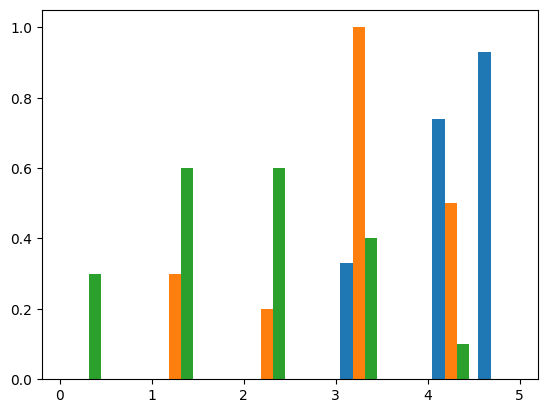

In [ ]:
with open('../final_data/alpaca_doc_naturalness.json', 'r') as f:
    data = json.load(f)
    scores = [p[1] for p in data]
with open('/share/shmatikov/collin/adversarial_decoding/final_data/jailbreak_only/AdvDec_meta-llama_Meta-Llama-3.1-8B-Instruct_jailbreak_200_natural_naturalness_score.json', 'r') as f:
    data = json.load(f)
    adv_scores = [p[1] for p in data]
with open('/share/shmatikov/collin/adversarial_decoding/final_data/jailbreak_only/AdvDec_meta-llama_Meta-Llama-3.1-8B-Instruct_jailbreak_200_unnatural_naturalness_score.json', 'r') as f:
    data = json.load(f)
    beast_scores = [p[1] for p in data]

print("adv readability avg", np.array(adv_scores).mean())
print("beast readability avg", np.array(beast_scores).mean())
plt.hist([scores, adv_scores, beast_scores], density=True)

adv readability avg 2.6
beast readability avg 1.65


(array([[0.    , 0.    , 0.    , 0.    , 0.    , 0.4125, 0.    , 0.925 ,
         0.    , 1.1625],
        [0.375 , 0.    , 0.75  , 0.    , 0.    , 0.875 , 0.    , 0.5   ,
         0.    , 0.    ],
        [1.5   , 0.    , 0.375 , 0.    , 0.    , 0.625 , 0.    , 0.    ,
         0.    , 0.    ]]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 3 BarContainer objects>)

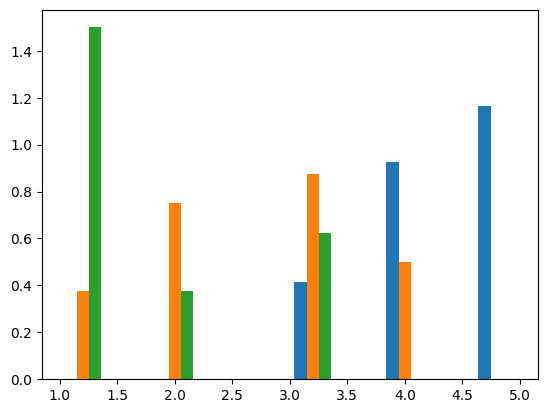

In [9]:
with open('../final_data/alpaca_doc_naturalness.json', 'r') as f:
    data = json.load(f)
    scores = [p[1] for p in data]
with open('/share/shmatikov/collin/adversarial_decoding/final_data/jailbreak_guard/jailbreak_guard_natural_beam20_topk10_skip10_natural005_readable_prompt_naturalness_score.json', 'r') as f:
    data = json.load(f)
    adv_scores = [p[1] for p in data]
with open('/share/shmatikov/collin/adversarial_decoding/final_data/jailbreak_guard/jailbreak_guard_unnatural_beam30_topk10_naturalness_score.json', 'r') as f:
    data = json.load(f)
    beast_scores = [p[1] for p in data]

print("adv readability avg", np.array(adv_scores).mean())
print("beast readability avg", np.array(beast_scores).mean())
plt.hist([scores, adv_scores, beast_scores], density=True)

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, random, json
from datasets import load_dataset
from tqdm import tqdm

torch.set_default_device('cuda:1')

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, random, json
from datasets import load_dataset
from tqdm import tqdm

torch.set_default_device('cuda:1')

class PerplexityMeasurer:

    def __init__(self):
        device = 'cuda:1'
        model_name = 'meta-llama/Llama-2-7b-chat-hf'
        self.causal_llm_tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.causal_llm_tokenizer.pad_token = self.causal_llm_tokenizer.eos_token
        self.causal_llm = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map=device)

    def compute_perplexity_batch(self, texts):
        inputs = self.causal_llm_tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'].to(self.causal_llm.device)
        attention_mask = inputs['attention_mask'].to(self.causal_llm.device)

        labels = input_ids.clone()
        labels[labels == self.causal_llm_tokenizer.pad_token_id] = -100  # Ignore padding tokens

        lm_logits = self.causal_llm(input_ids=input_ids, attention_mask=attention_mask).logits

        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_masks = attention_mask[..., 1:].contiguous()

        loss_fct = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=-100)
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        loss = loss.view(shift_labels.shape[0], -1) * shift_masks
        loss = loss.sum(dim=-1) / shift_masks.sum(dim=-1)  # Normalize by the number of valid tokens

        return torch.exp(loss).tolist()  # Convert loss to perplexity

    def compute_perplexity(self, texts):
        chunk_size = 10
        perplexities = []
        for i in tqdm(range(0, len(texts), chunk_size)):
            perplexities.extend(self.compute_perplexity_batch(texts[i:i+chunk_size]))
        return perplexities


/home/rz454/miniconda3/envs/refusal_direction/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
docs = []
perplexities = []
measurer = PerplexityMeasurer()
# print(docs)
# print(adv_docs)
# print(beast_docs)

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


In [24]:
with open('../final_data/rag_doc_naturalness.json', 'r') as f:
    data = json.load(f)
    docs = [p[0] for p in data]
    doc_pp = measurer.compute_perplexity(docs)

with open('../final_data/rag/full_sent_contriever_llama_bias_asr_beam30_length30_topk_10.json', 'r') as f:
    data = json.load(f)
    adv_docs = []
    for p in data:
        for r in p['result']:
            adv_docs.append(r)
    adv_pp = measurer.compute_perplexity(adv_docs)

with open('../final_data/rag/full_sent_contriever_llama_bias_asr_beam30_length30_topk_10_beast.json', 'r') as f:
    data = json.load(f)
    beast_docs = []
    for p in data:
        for r in p['result']:
            beast_docs.append(r)
    beast_pp = measurer.compute_perplexity(beast_docs)

100%|██████████| 3/3 [00:00<00:00,  9.46it/s]


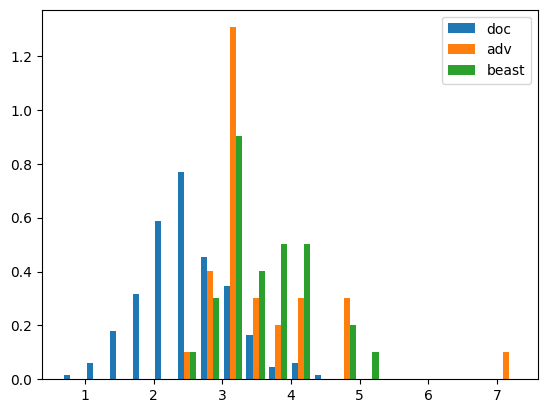

In [30]:
import matplotlib.pyplot as plt
# x axis should have log scale
plt.hist([np.log(doc_pp), np.log(adv_pp), np.log(beast_pp)], density=True, bins=20)
plt.legend(['doc', 'adv', 'beast'])

In [23]:
adv_pp

[53.634395599365234,
 122.59445190429688,
 66.23895263671875,
 155.09942626953125,
 492.8342590332031,
 66.8060531616211,
 163.60360717773438,
 91.80464935302734,
 44.907840728759766,
 196.45843505859375,
 110.67012786865234,
 61.562347412109375,
 111.97333526611328,
 83.15685272216797,
 149.5825958251953,
 101.89067077636719,
 65.03749084472656,
 256.05712890625,
 156.0161590576172,
 198.13461303710938]

In [19]:
import numpy as np
print("adv perplexity avg", np.median(adv_pp))
print("beast perplexity avg", np.median(beast_pp))
print("doc perplexity avg", np.median(doc_pp))
print((np.array(doc_pp) > 80).sum())

adv perplexity avg 111.32173156738281
beast perplexity avg 29.67519474029541
doc perplexity avg 35.24078369140625
34


/tmp/ipykernel_2740371/1044395506.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['doc', 'adv', 'beast'])


[Text(0, 0, 'doc'), Text(1, 0, 'adv'), Text(2, 0, 'beast')]

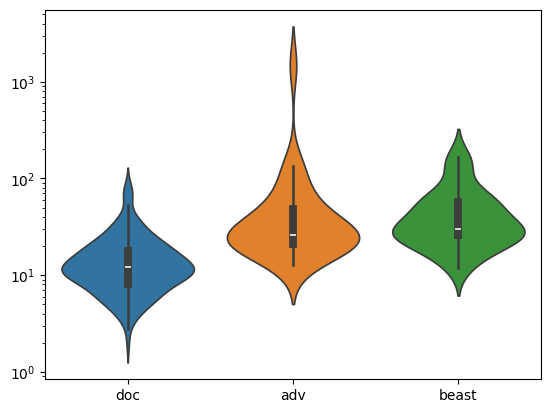

In [6]:
from seaborn import violinplot
# add legend to plot
data = [doc_pp, adv_pp, beast_pp]
ax = violinplot(data=data, log_scale=True)
ax.set_xticklabels(['doc', 'adv', 'beast'])

In [18]:
with open('/share/shmatikov/collin/adversarial_decoding/final_data/alpaca_doc_naturalness.json', 'r') as f:
    data = json.load(f)
    docs = [p[0] for p in data]
    doc_pp = measurer.compute_perplexity(docs)

with open('/share/shmatikov/collin/adversarial_decoding/final_data/jailbreak_only/AdvDec_meta-llama_Meta-Llama-3.1-8B-Instruct_jailbreak_200_natural.json', 'r') as f:
    data = json.load(f)
    adv_docs = []
    for p in data:
        adv_docs.append(p['adv_suffix'])
    adv_pp = measurer.compute_perplexity(adv_docs)

with open('/share/shmatikov/collin/adversarial_decoding/final_data/jailbreak_only/AdvDec_meta-llama_Meta-Llama-3.1-8B-Instruct_jailbreak_200_unnatural.json', 'r') as f:
    data = json.load(f)
    beast_docs = []
    for p in data:
        beast_docs.append(p['adv_suffix'])
    beast_pp = measurer.compute_perplexity(beast_docs)

  0%|          | 0/10 [00:00<?, ?it/s]/home/rz454/miniconda3/envs/refusal_direction/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


In [34]:
(np.array(doc_pp) > 100).sum()

24

/tmp/ipykernel_2740371/1274128957.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['doc', 'adv', 'beast'])


(-200.0, 1000.0)

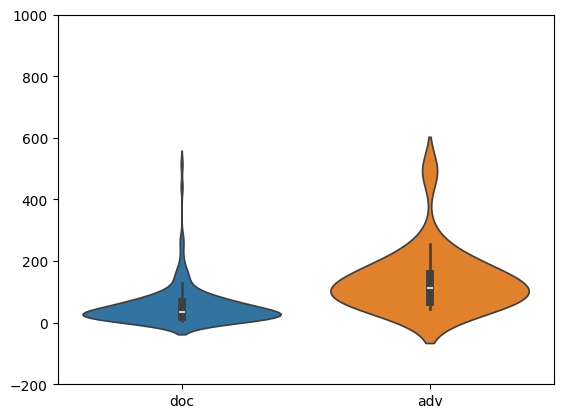

In [18]:
from seaborn import violinplot
# add legend to plot
data = [doc_pp, adv_pp]
ax = violinplot(data=data)
ax.set_xticklabels(['doc', 'adv', 'beast'])
ax.set_ylim(bottom=-200, top=1000)

In [15]:
with open('/share/shmatikov/collin/adversarial_decoding/new_data/jailbreak_llama_natural.json', 'r') as f:
    data = json.load(f)
    adv_docs = []
    for p in data:
        adv_docs.append(p['adv_suffix'])
    adv_pp = measurer.compute_perplexity(adv_docs)

100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


In [16]:
adv_pp

[53.634395599365234,
 122.59445190429688,
 66.23895263671875,
 155.09942626953125,
 492.8342590332031,
 66.8060531616211,
 163.60360717773438,
 91.80464935302734,
 44.907840728759766,
 196.45843505859375,
 110.67012786865234,
 61.562347412109375,
 111.97333526611328,
 83.15685272216797,
 149.5825958251953,
 101.89067077636719,
 65.03749084472656,
 256.05712890625,
 156.0161590576172,
 198.13461303710938]

In [17]:
with open('/share/shmatikov/collin/adversarial_decoding/final_data/alpaca_doc_naturalness.json', 'r') as f:
    data = json.load(f)
    docs = [p[0] for p in data]
    doc_pp = measurer.compute_perplexity(docs)

100%|██████████| 20/20 [00:01<00:00, 15.37it/s]


In [11]:
from datasets import load_dataset

ds = load_dataset("swj0419/WikiMIA")

In [12]:
unseen_data = []
for p in ds['WikiMIA_length128']:
    if p['label'] == 1:
        unseen_data.append(p['input'])

In [13]:
unseen_pp = measurer.compute_perplexity(unseen_data)

100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


In [14]:
import numpy as np
np.array(unseen_pp).mean()

7.2683346425886635

In [16]:
doc_pp

[12.679559707641602,
 101.51250457763672,
 48.47578811645508,
 54.79877471923828,
 71.22703552246094,
 28.583850860595703,
 163.7607879638672,
 18.016767501831055,
 32.6816520690918,
 115.0719223022461,
 17.87066078186035,
 172.5321044921875,
 33.81809997558594,
 11.601412773132324,
 21.932018280029297,
 57.96383285522461,
 42.8641242980957,
 18.583969116210938,
 30.493865966796875,
 69.6288070678711,
 19.416099548339844,
 118.03692626953125,
 44.413047790527344,
 36.95854949951172,
 21.582176208496094,
 54.1456298828125,
 21.14235496520996,
 17.433320999145508,
 34.84415817260742,
 33.0578498840332,
 41.824913024902344,
 24.320907592773438,
 63.33085250854492,
 62.645816802978516,
 49.776912689208984,
 42.76748275756836,
 14.075623512268066,
 194.76995849609375,
 31.460742950439453,
 54.24433898925781,
 21.548471450805664,
 44.23472213745117,
 27.258281707763672,
 13.92091178894043,
 115.44427490234375,
 41.193267822265625,
 137.6833953857422,
 177.4767608642578,
 20.06879234313965,
 